In [1]:
import sys
print(sys.executable)

C:\Users\godcl\AppData\Local\Programs\Python\Python311\python.exe


In [2]:
from IPython.display import Image

In [3]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import ks_2samp, ttest_ind, t
from arch import arch_model
# Загрузка исторических данных о валютных курсах
data = yf.download("USDRUB=X EURRUB=X", start="2013-01-01", end="2023-04-13")

[*********************100%%**********************]  2 of 2 completed


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2680 entries, 2013-01-01 to 2023-04-12
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   (Adj Close, EURRUB=X)  2680 non-null   float64
 1   (Adj Close, USDRUB=X)  2678 non-null   float64
 2   (Close, EURRUB=X)      2680 non-null   float64
 3   (Close, USDRUB=X)      2678 non-null   float64
 4   (High, EURRUB=X)       2680 non-null   float64
 5   (High, USDRUB=X)       2678 non-null   float64
 6   (Low, EURRUB=X)        2680 non-null   float64
 7   (Low, USDRUB=X)        2678 non-null   float64
 8   (Open, EURRUB=X)       2680 non-null   float64
 9   (Open, USDRUB=X)       2678 non-null   float64
 10  (Volume, EURRUB=X)     2680 non-null   int64  
 11  (Volume, USDRUB=X)     2678 non-null   float64
dtypes: float64(11), int64(1)
memory usage: 272.2 KB


In [5]:
print(data['Close'].tail(10))

Ticker       EURRUB=X   USDRUB=X
Date                            
2023-03-30  83.838997  77.290001
2023-03-31  84.256203  77.239998
2023-04-03  84.555298  77.964996
2023-04-04  85.794800  78.614998
2023-04-05  86.892403  79.264999
2023-04-06  87.445602  80.165001
2023-04-07  88.682098  81.165001
2023-04-10  88.682098  81.065002
2023-04-11  88.682098  81.625000
2023-04-12  88.532402  81.065002


In [6]:
usd_rates = data['Close']['USDRUB=X'].dropna()
eur_rates = data['Close']['EURRUB=X'].dropna()

In [7]:
#usd_rates,eur_rates = usd_rates.loc[(usd_rates>20)],eur_rates.loc[(eur_rates>20)]

In [8]:
usd_rates.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 2678 entries, 2013-01-01 to 2023-04-12
Series name: USDRUB=X
Non-Null Count  Dtype  
--------------  -----  
2678 non-null   float64
dtypes: float64(1)
memory usage: 41.8 KB


In [9]:
def simulate_exchange_rates(historical_rates, days, simulations, drifts, volatilities):
    dt = 1 / days
    simulated_rates = {}
    for currency, rates in historical_rates.items():
        drift = drifts[currency]
        volatility = volatilities[currency]
        daily_returns = np.exp((drift - 0.5 * volatility**2) * dt + 
                               volatility * np.random.normal(0, np.sqrt(dt), (days, simulations)))
        simulation = rates.iloc[-1] * np.cumprod(daily_returns, axis=0)
        simulated_rates[currency] = simulation
    return simulated_rates

![формула GBM](Screenshot_1.png)

In [10]:
def portfolio_value(simulated_rates, portfolio):
    simulations = next(iter(simulated_rates.values())).shape[1]
    values = np.full(simulations, portfolio.get('RUB', 0), dtype=float)  
    for currency, amount in portfolio.items():
        if currency != 'RUB':
            values += amount * simulated_rates[currency][-1, :]
    return values

In [11]:
def calculate_var(portfolio_values, confidence_level=0.95):
    sorted_values = np.sort(portfolio_values)
    index = int((1 - confidence_level) * len(sorted_values))
    return sorted_values[index]

In [ ]:
def calculate_cvar(portfolio_values, confidence_level=0.95):
    var = calculate_var(portfolio_values, confidence_level)
    cvar = portfolio_values[portfolio_values <= var].mean()
    return cvar
def calculate_confidence_interval(simulated_data, confidence_level=0.95):
    lower_percentile = (1 - confidence_level) / 2 * 100
    upper_percentile = (1 - (1 - confidence_level) / 2) * 100
    lower_bound = np.percentile(simulated_data, lower_percentile)
    upper_bound = np.percentile(simulated_data, upper_percentile)
    return lower_bound, upper_bound

In [13]:
def calculate_drift_volatility(rates, lookback_period=252):
    log_returns = np.log(rates / rates.shift(1)).dropna()
    rolling_mean = log_returns.rolling(window=lookback_period).mean()
    rolling_std = log_returns.rolling(window=lookback_period).std()
    drift = rolling_mean.iloc[-1]
    volatility = rolling_std.iloc[-1]
    return drift, volatility

In [14]:
def calculate_confidence_interval(simulated_data, confidence_level=0.95):
    lower_percentile = (1 - confidence_level) / 2 * 100
    upper_percentile = (1 - (1 - confidence_level) / 2) * 100
    lower_bound = np.percentile(simulated_data, lower_percentile)
    upper_bound = np.percentile(simulated_data, upper_percentile)
    return lower_bound, upper_bound

In [15]:
def fit_garch_model(log_returns):
    # Подгонка ГАРЧ модели к логарифмическим доходностям
    model = arch_model(log_returns, vol='Garch', p=1, q=1)
    model_fit = model.fit(disp='off')  # disp='off' отключает вывод сообщений оптимизации
    
    # Получаем параметр долгосрочного среднего из условной волатильности модели ГАРЧ
    omega, alpha, beta = model_fit.params['omega'], model_fit.params['alpha[1]'], model_fit.params['beta[1]']
    long_run_volatility = np.sqrt(omega / (1 - alpha - beta))
    
    # Извлечение условной волатильности и предсказанных средних значений
    predicted_mean = model_fit.params['mu']
    return predicted_mean, long_run_volatility

In [16]:
historical_rates = {'USD': usd_rates, 'EUR': eur_rates}
days = 252
simulations = 1000000
# Расчет дрейфа и волатильности для Моделирования
drifts = {}
volatilities = {}
for currency, rates in historical_rates.items():
    drifts[currency], volatilities[currency] = calculate_drift_volatility(rates)
usd_log_returns = np.log(usd_rates / usd_rates.shift(1)).dropna()
eur_log_returns = np.log(eur_rates / eur_rates.shift(1)).dropna()

usd_drift_garch, usd_volatility_garch = fit_garch_model(usd_log_returns)
eur_drift_garch, eur_volatility_garch = fit_garch_model(eur_log_returns)

# Обновление словарей дрейфов и волатильности для использования в симуляции Монте-Карло
drifts['USD'] = usd_drift_garch
drifts['EUR'] = eur_drift_garch
volatilities['USD'] = usd_volatility_garch
volatilities['EUR'] = eur_volatility_garch
# Моделирование курсов валют
simulated_rates = simulate_exchange_rates(historical_rates, days, simulations, drifts, volatilities)

# Ввод данных пользователем
rub_amount = float(input("Введите количество рублей: "))
usd_amount = float(input("Введите количество долларов: "))
eur_amount = float(input("Введите количество евро: "))

# Получение данных пользователя
portfolio = {'RUB': rub_amount, 'USD': usd_amount, 'EUR': eur_amount}
# Расчет стоимости портфеля
portfolio_values = portfolio_value(simulated_rates, portfolio)

C:\Users\godcl\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0225. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\godcl\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000695. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Введите количество рублей:  0
Введите количество долларов:  1
Введите количество евро:  0


In [17]:
cvar = calculate_cvar(portfolio_values)
print(f"Максимальный риск портфеля (95% довер): {cvar}")

Максимальный риск портфеля (95% довер): 62.670256935049224


In [18]:
data_recent = yf.download("USDRUB=X EURRUB=X", start="2023-04-12", end="2024-04-13")['Close'].dropna()
data_recent_usd = data_recent['USDRUB=X'].dropna()
data_recent_eur = data_recent['EURRUB=X'].dropna()

[*********************100%%**********************]  2 of 2 completed


In [19]:
real_data_last_year = data_recent_usd[-days:]
simulated_data_first_path = simulated_rates['USD'][:, 0]

ks_stat, p_value_ks = ks_2samp(real_data_last_year, simulated_data_first_path)
t_stat, p_value_t = ttest_ind(real_data_last_year, simulated_data_first_path, equal_var=False)

print(f"KS Statistic: {ks_stat}, P-value (KS-test): {p_value_ks}")
print(f"T-statistic: {t_stat}, P-value (T-test): {p_value_t}")

KS Statistic: 0.2896825396825397, P-value (KS-test): 1.0072185593990747e-09
T-statistic: -2.5458820588511593, P-value (T-test): 0.01120216411886571


In [20]:
usd_confidence_interval = calculate_confidence_interval(simulated_rates['USD'][-1, :])
eur_confidence_interval = calculate_confidence_interval(simulated_rates['EUR'][-1, :])

print(f"Доверительный интервал 95% для курса доллара: {usd_confidence_interval}")
print(f"Доверительный интервал 95% для курса евро: {eur_confidence_interval}")

Доверительный интервал 95% для курса доллара: (63.396550341391, 101.93707447919887)
Доверительный интервал 95% для курса евро: (84.04805090952163, 93.19216724331068)


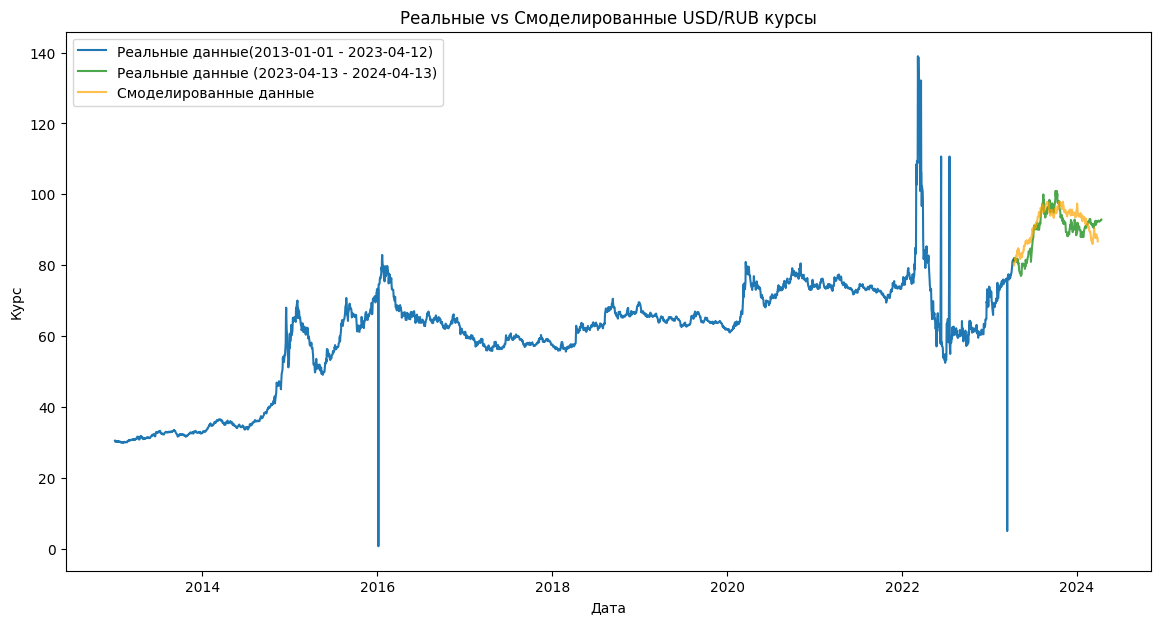

In [53]:
# Визуализация исторических и симулированных данных
plt.figure(figsize=(14, 7))
plt.plot(usd_rates.index, usd_rates, 
         label='Реальные данные(2013-01-01 - 2023-04-12)')
plt.plot(data_recent_usd.index, data_recent_usd, 
         label='Реальные данные (2023-04-13 - 2024-04-13)', color='green', alpha=0.7)
plt.plot(pd.date_range(start=usd_rates.index[-1], periods=days, freq='B'),
         simulated_rates['USD'][:, 0], label='Смоделированные данные', color='orange', alpha=0.7)
plt.legend()
plt.title('Реальные vs Смоделированные USD/RUB курсы')
plt.xlabel('Дата')
plt.ylabel('Курс')
plt.savefig('RUBUSD.png')
plt.show()

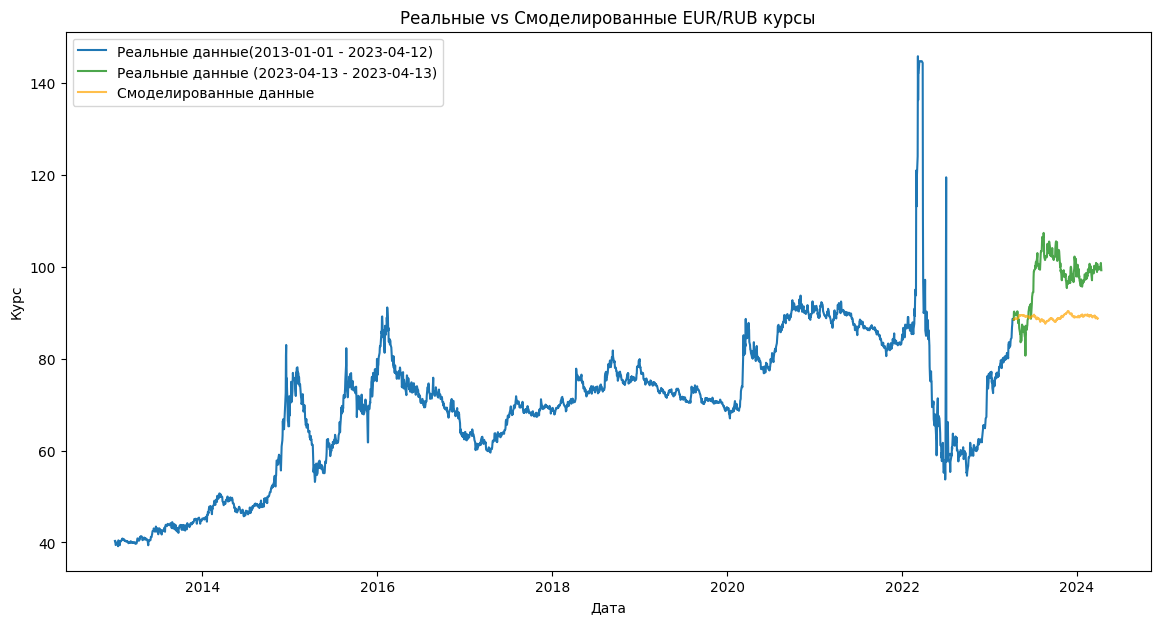

In [54]:
# Визуализация исторических и симулированных данных
plt.figure(figsize=(14, 7))
plt.plot(eur_rates.index, eur_rates, 
         label='Реальные данные(2013-01-01 - 2023-04-12)')
plt.plot(data_recent_eur.index, data_recent_eur, 
         label='Реальные данные (2023-04-13 - 2023-04-13)', color='green', alpha=0.7)
plt.plot(pd.date_range(start=eur_rates.index[-1], periods=days, freq='B'),
         simulated_rates['EUR'][:, 0], label='Смоделированные данные', color='orange', alpha=0.7)
plt.legend()
plt.title('Реальные vs Смоделированные EUR/RUB курсы')
plt.xlabel('Дата')
plt.ylabel('Курс')
plt.savefig('RUBEUR.png')
plt.show()

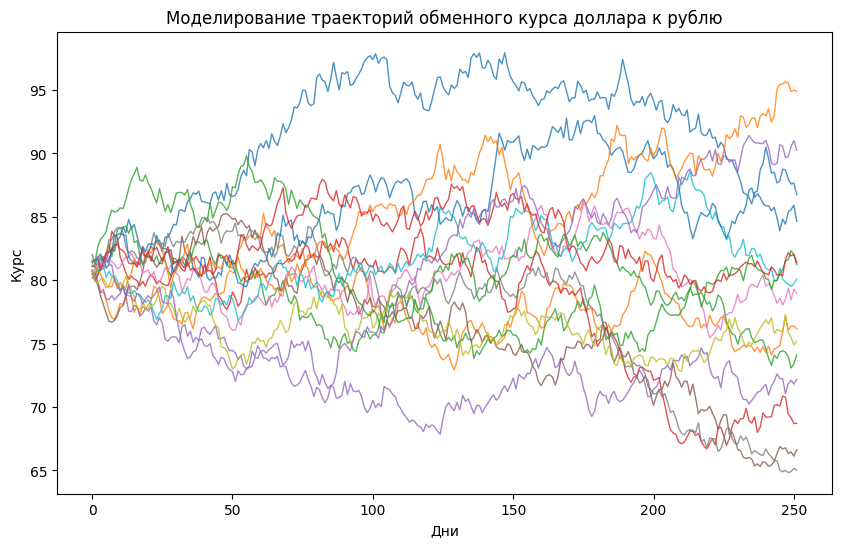

In [24]:
plt.figure(figsize=(10, 6))
for i in range(15):
    plt.plot(simulated_rates['USD'][:, i], linewidth=1, alpha=0.8)
plt.title('Моделирование траекторий обменного курса доллара к рублю')
plt.xlabel('Дни')
plt.ylabel('Курс')
plt.show()

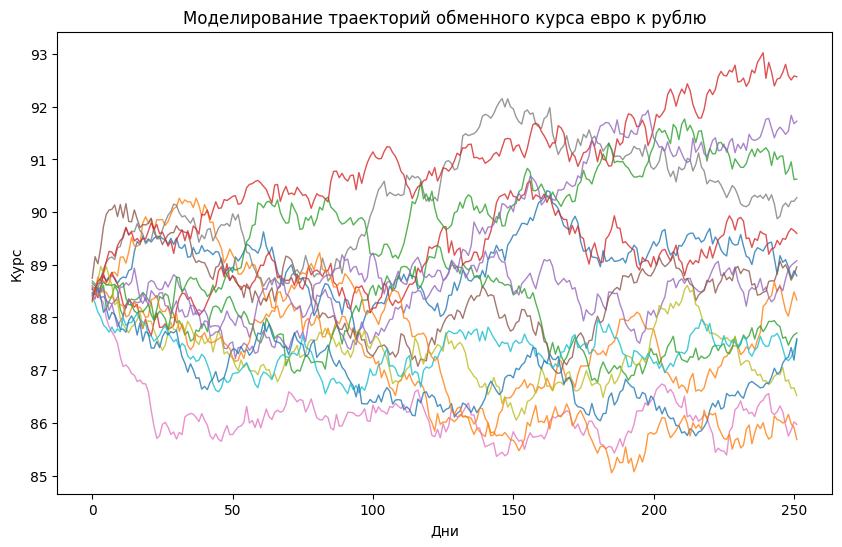

In [31]:
plt.figure(figsize=(10, 6))
for i in range(15):
    plt.plot(simulated_rates['EUR'][:, i], linewidth=1, alpha=0.8)
plt.title('Моделирование траекторий обменного курса евро к рублю')
plt.xlabel('Дни')
plt.ylabel('Курс')
plt.show()

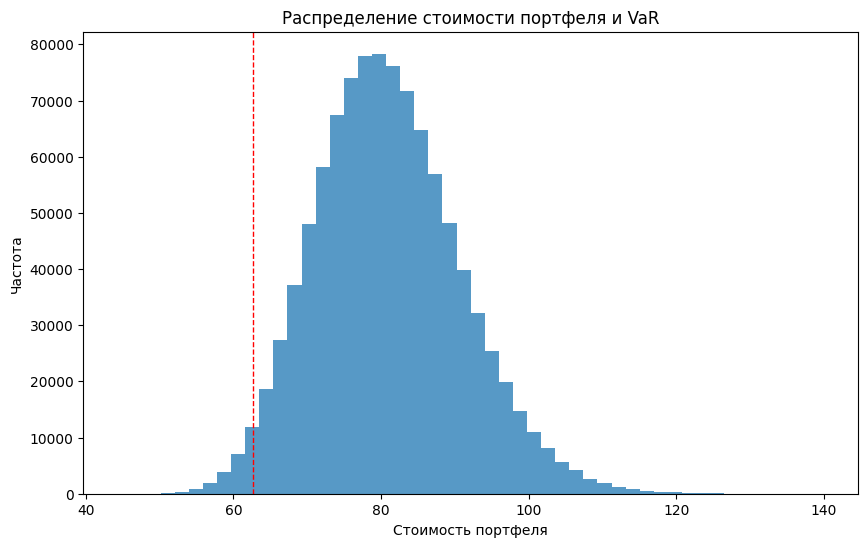

In [25]:
plt.figure(figsize=(10, 6))
plt.hist(portfolio_values, bins=50, alpha=0.75)
plt.axvline(x=cvar, color='r', linestyle='dashed', linewidth=1)
plt.title('Распределение стоимости портфеля и VaR')
plt.xlabel('Стоимость портфеля')
plt.ylabel('Частота')
plt.show()

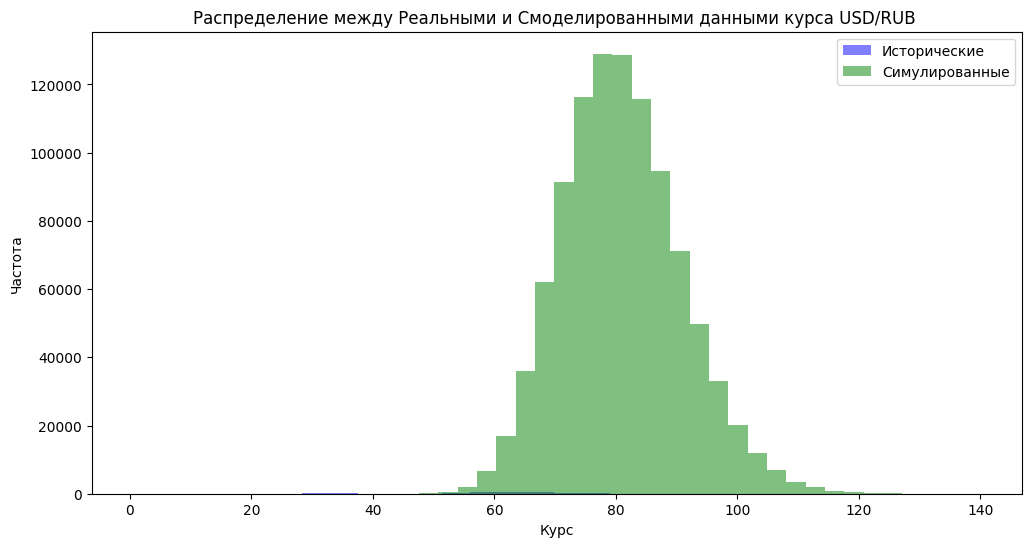

In [26]:
# Реальные исторические данные
plt.figure(figsize=(12, 6))
plt.hist(usd_rates, bins=30, alpha=0.5, label='Исторические', color='blue')

# Симулированные данные на конец периода
simulated_final = simulated_rates['USD'][-1, :]
plt.hist(simulated_final, bins=30, alpha=0.5, label='Симулированные', color='green')

plt.xlabel('Курс')
plt.ylabel('Частота')
plt.title('Распределение между Реальными и Смоделированными данными курса USD/RUB ')
plt.legend()
plt.show()

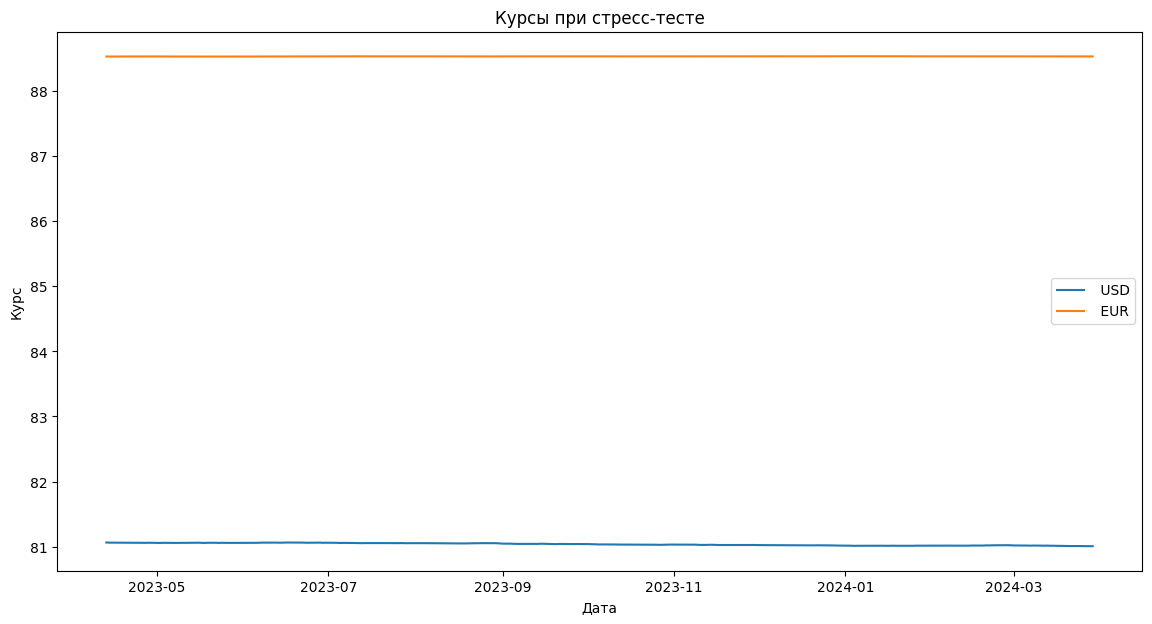

In [27]:
def stress_test(historical_rates, days, simulations, drifts, volatilities, stress_scenario):
    stressed_drifts = drifts.copy()
    stressed_volatilities = volatilities.copy()

    for currency in stressed_drifts:
        stressed_drifts[currency] *= stress_scenario['drift_change']
        stressed_volatilities[currency] *= stress_scenario['volatility_change']

    stressed_simulated_rates = simulate_exchange_rates(
        historical_rates, days, simulations, stressed_drifts, stressed_volatilities
    )

    return stressed_simulated_rates

stress_scenario = {
    'drift_change': 0.5,  
    'volatility_change': 2.0 
}

stressed_simulated_rates = stress_test(historical_rates, days, simulations, drifts, volatilities, stress_scenario)

plt.figure(figsize=(14, 7))
for currency in stressed_simulated_rates:
    plt.plot(pd.date_range(start='2023-04-13', periods=days, freq='B'), 
             stressed_simulated_rates[currency].mean(axis=1), 
             label=f' {currency}')

plt.title('Курсы при стресс-тесте')
plt.xlabel('Дата')
plt.ylabel('Курс')
plt.legend()
plt.show()

In [33]:
historical_rates_pred = {'USD': data_recent_usd, 'EUR': data_recent_eur}
days_pred= 252
simulations_pred = 1000000
# Расчет дрейфа и волатильности для Моделирования
drifts_pred = {}
volatilities_pred = {}
for currency_pred, rates_pred in historical_rates_pred.items():
    drifts_pred[currency_pred], volatilities_pred[currency_pred] = calculate_drift_volatility(rates_pred)
usd_log_returns_pred = np.log(usd_rates / usd_rates.shift(1)).dropna()
eur_log_returns_pred = np.log(eur_rates / eur_rates.shift(1)).dropna()

usd_drift_garch_pred, usd_volatility_garch_pred = fit_garch_model(usd_log_returns_pred)
eur_drift_garch_pred, eur_volatility_garch_pred = fit_garch_model(eur_log_returns_pred)

# Обновление словарей дрейфов и волатильности для использования в симуляции Монте-Карло
drifts_pred['USD'] = usd_drift_garch_pred
drifts_pred['EUR'] = eur_drift_garch_pred
volatilities_pred['USD'] = usd_volatility_garch_pred
volatilities_pred['EUR'] = eur_volatility_garch_pred
# Моделирование курсов валют
simulated_rates_pred = simulate_exchange_rates(historical_rates_pred, days_pred, simulations_pred, drifts_pred, volatilities_pred)

# Ввод данных пользователем
rub_amount_pred = float(input("Введите количество рублей: "))
usd_amount_pred = float(input("Введите количество долларов: "))
eur_amount_pred = float(input("Введите количество евро: "))

# Получение данных пользователя
portfolio_pred = {'RUB': rub_amount_pred, 'USD': usd_amount_pred, 'EUR': eur_amount_pred}
# Расчет стоимости портфеля
portfolio_values_pred = portfolio_value(simulated_rates_pred, portfolio_pred)

C:\Users\godcl\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0225. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\godcl\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000695. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Введите количество рублей:  0
Введите количество долларов:  1000
Введите количество евро:  0


In [34]:
cvar_pred = calculate_cvar(portfolio_values_pred)
print(f"Максимальный риск портфеля (95% довер): {cvar_pred}")

Максимальный риск портфеля (95% довер): 71827.22023513853


In [36]:
usd_confidence_interval_pred = calculate_confidence_interval(simulated_rates_pred['USD'][-1, :])
eur_confidence_interval_pred = calculate_confidence_interval(simulated_rates_pred['EUR'][-1, :])
print(f"Доверительный интервал 95% для курса доллара: {usd_confidence_interval_pred }")
print(f"Доверительный интервал 95% для курса евро: {eur_confidence_interval_pred }")

Доверительный интервал 95% для курса доллара: (72.63404780533205, 116.80234915827717)
Доверительный интервал 95% для курса евро: (94.25965585147713, 104.5288904591821)


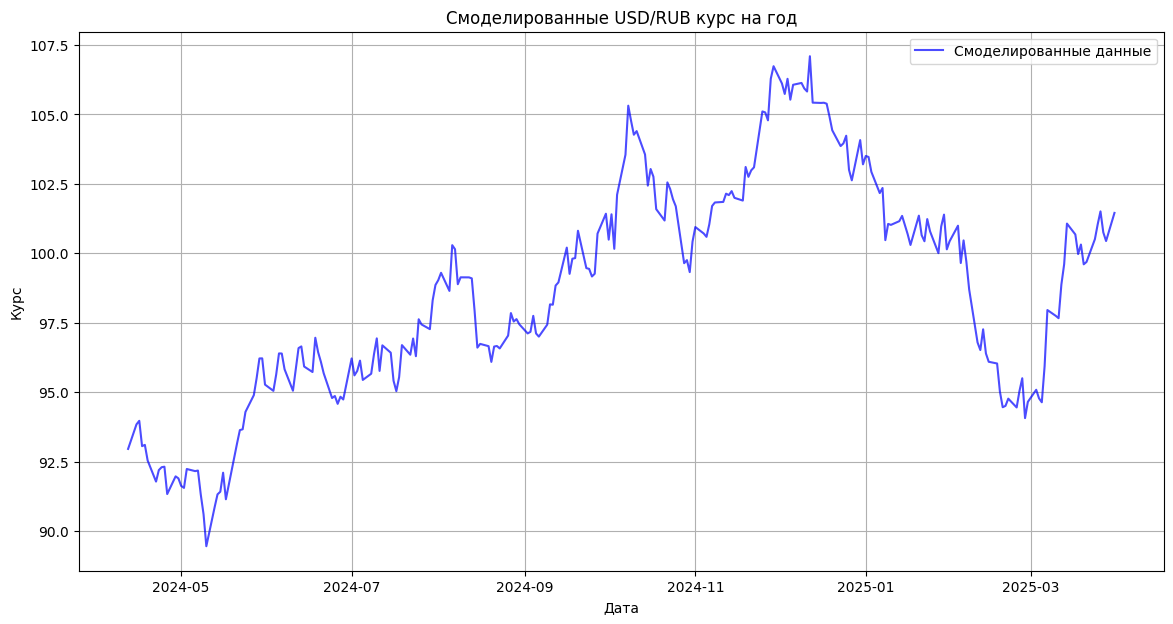

In [52]:
# Визуализация исторических и симулированных данных
plt.figure(figsize=(14, 7))
plt.plot(pd.date_range(start=data_recent_usd.index[-1], periods=days, freq='B'),
         simulated_rates_pred['USD'][:, 0], label='Смоделированные данные', color='blue', alpha=0.7)
plt.legend()
plt.title('Смоделированные USD/RUB курс на год')
plt.xlabel('Дата')
plt.ylabel('Курс')
plt.grid()
plt.savefig('RUBUSD_pred.png')
plt.show()